# Simple Color Analysis for Datasets


The idea is to see whether the images of a dataset are particularily skewed in their color distribution. This might be interesting as it could influence the model training on the data for the colorization task. 

The approach here is to simply extract the three most common colors of an image and then collect these most common colors for all images in the dataset and look again at the most common colors of all these most common colors to get a good indication on what the overall color scheme of the images of the dataset is.

In [1]:
from collections import Counter
from sklearn.cluster import KMeans
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import itertools
import collections
from tqdm import tqdm
# import warnings filter
from warnings import simplefilter
# ignore all future warnings (this should be done only when well-thought-out)
simplefilter(action='ignore', category=FutureWarning)

Code inspired by https://towardsdatascience.com/building-an-image-color-analyzer-using-python-12de6b0acf74 

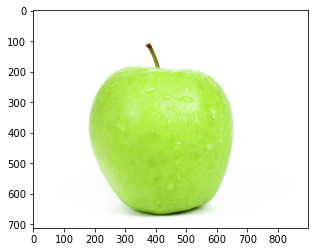

In [2]:
# example of an image from the dataset 
image = cv2.imread('data/ColorfulOriginal/Apple/Apple1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

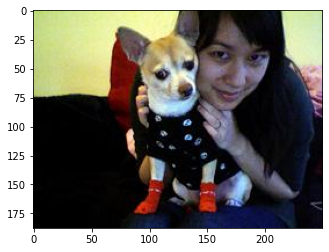

In [3]:
image = cv2.imread('data/Images/n02085620-Chihuahua/n02085620_7.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## Functions:

In [4]:
def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        i = int(i)
        hex_color += ("{:02x}".format(i))
    return hex_color

In [5]:
def color_analysis(img_path):
    
    # open picture with given path
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # prepare image by resizing and reshaping it 
    image = cv2.resize(image, (900, 600), interpolation = cv2.INTER_AREA)
    image = image.reshape(image.shape[0] * image.shape[1], 3)
    
    # extract the 3 most common colors in the image
    clf = KMeans(n_clusters = 3)
    color_labels = clf.fit_predict(image)
    center_colors = clf.cluster_centers_    
    counts = Counter(color_labels)
    ordered_colors = [center_colors[i] for i in counts.keys()]
    # save the hex numbers of the colors
    hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()] 
    return hex_colors

In [11]:
def get_folder_names(directory_path):
    
    folder_list = list()
    directory = os.fsencode(directory_path)
    
    for folder in os.listdir(directory):
        folder_list.append(os.fsdecode(os.path.join(directory, folder)))
        
    return folder_list 

In [15]:
def run_color_analysis(directory_path):
    
    folder_list = get_folder_names(directory_path)
    
    all_colors = list()
    
    for folder in tqdm(folder_list , desc='number of processed image-subfolder'):
        directory = os.fsencode(folder)
    
        for file in os.listdir(directory):
            filename = os.fsdecode(os.path.join(directory, file))
            if filename.endswith(".jpg"): 
                hex_colors = color_analysis(filename)
                all_colors.append(hex_colors)   
                
    # all colors includes always triplets for each image, so we must flatten the list          
    flat_list_colors = itertools.chain(*all_colors)
    colors = list(flat_list_colors)
    # count occurences of hex codes and sort them from most frequent to less
    most_common_colors = collections.Counter(colors).most_common()
    # get hex values and counts from the sorted list 
    values, counts = zip(*most_common_colors)
    
    # pie figures to visualize the most common colors of the dataset
    # all colors
    plt.figure(figsize = (12, 8))
    plt.pie(counts, labels = values, colors = values)
    plt.savefig(directory_path + "color_analysis_complete.png")  
    
    # the 100 most 
    plt.figure(figsize = (12, 8))
    plt.pie(counts[:100], labels = values[:100], colors = values[:100])
    plt.savefig(directory_path + "color_analysis_top100.png")  
    
    # the between 50 and 150 most (this is included because e.g. different shades of white as background color can rank as the first 100)
    plt.figure(figsize = (12, 8))
    plt.pie(counts[50:150], labels = values[50:150], colors = values[50:150])
    plt.savefig(directory_path + "color_analysis_middleground.png")     

## Analysis: 

* Dataset with fruit images
* Dog Dataset with reduced number of images (dataset is very huge)

number of processed image-subfolder: 100%|█████████████████████████████████████████████| 20/20 [21:34<00:00, 64.73s/it]


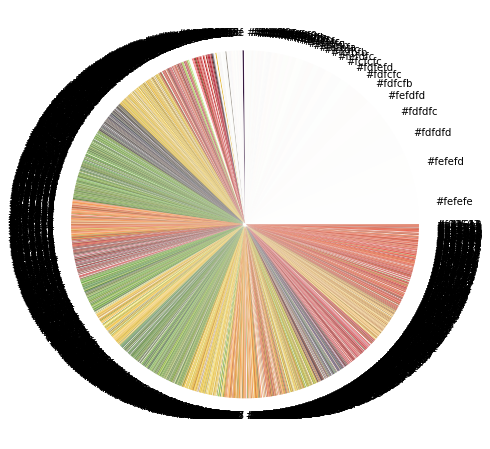

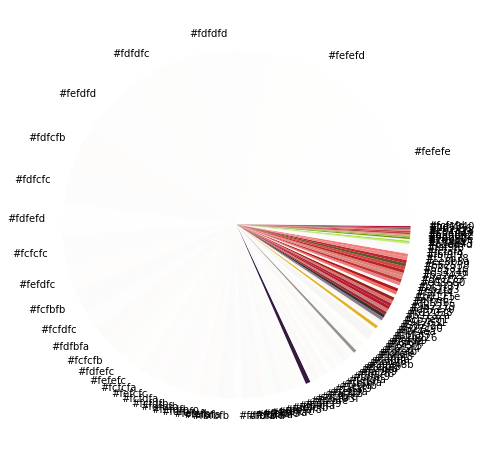

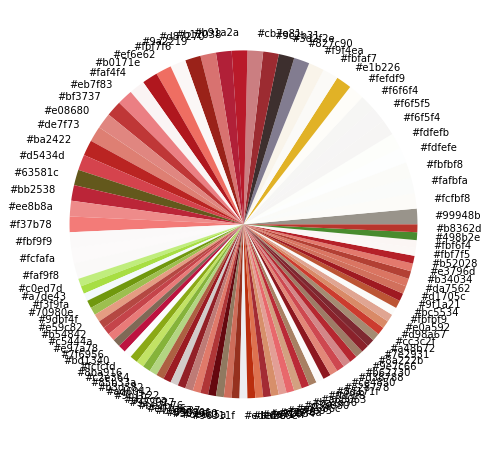

In [16]:
run_color_analysis('data/ColorfulOriginal')

The dataset of fruits and veggies seems to be mostly skewed towards red, green and white(i.e. the white background) and some yellow. This is sensible as most included fruits/veggies are in fact red and green and also mostly include one of these colors or maybe two. Thus, it seems not that surprising that a model is able to predict these quite distinct colors quite well. 

number of processed image-subfolder: 100%|███████████████████████████████████████████| 120/120 [58:40<00:00, 29.34s/it]


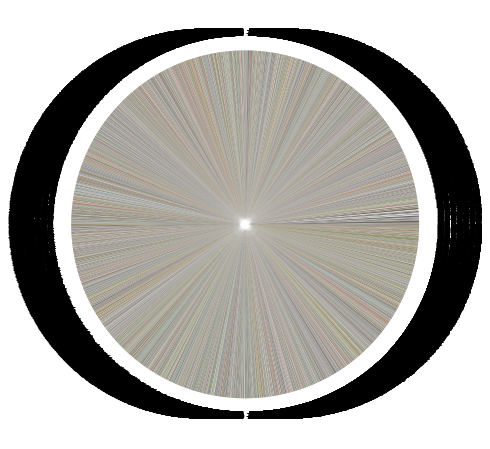

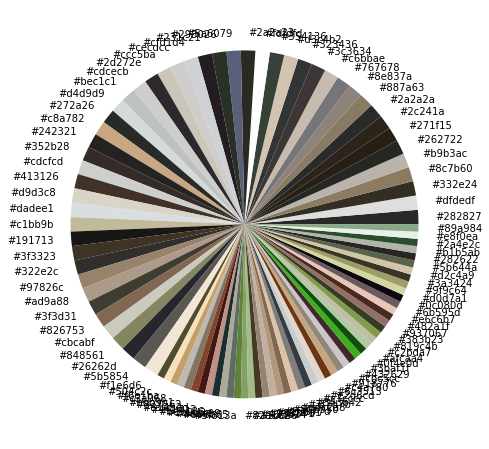

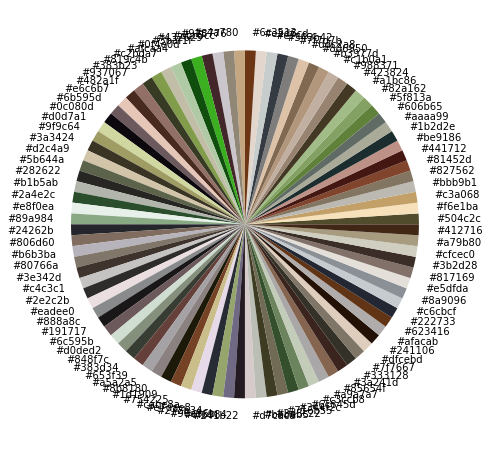

In [19]:
run_color_analysis('data/Images_reduced')

It seems to be that the dog dataset is very skewed towards brown-grey colors and some green tones. This makes a lot of sense since most dog-fur is along the colors of black, white, brown, grey and dogs are often depicted outside with green-ish nature in the background. However, those predominant colors can potentially cause the model to learn a beige/brown-ish filter as this seems to be the most common color (and thus is correct most of the time when the model learns color distribution during training).

Of course, there are also other factors that can influence the model and what it learns during training. 
A qualitative analysis by looking through the images revealed that there are multiple factors that can hinder a model to learn appropriate colorization and classification. 
Among those factors are: 

* humans or other object in the picture that are predominant (i.e. take up more space than the dog)
* sometimes pictures of dogs in costumes are included; the costumes are distracting from the actual visual traits of the dog breed
* naturalistic depictions of dogs in nature often mean that there is mostly nature to be seen in the image
* the dataset includes 120 dog breeds - the task to classify a dog correctly would be very hard for a human; so it might not be as surpising if the model struggles as well